In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Download data set from https://www.dropbox.com/s/q8hzc5x26q6a9q5/ieee-fraud-detection.zip?dl=0 and upload in google drive. 
# All data set is read from google drive.Issue with Phone verification for direct Kaggle Downloads

In [0]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn import preprocessing
import random
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
%matplotlib inline

In [0]:
train_identity = pd.read_csv('gdrive/My Drive/Week3/train_identity.csv')
train_transaction = pd.read_csv('gdrive/My Drive/Week3/train_transaction.csv')
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [34]:
train_identity.shape

(144233, 41)

In [35]:
train_transaction.shape

(590540, 394)

In [36]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [3]:
fraud = train.loc[train['isFraud'] == 1]
non_frauds = train.loc[train['isFraud'] == 0]
train.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

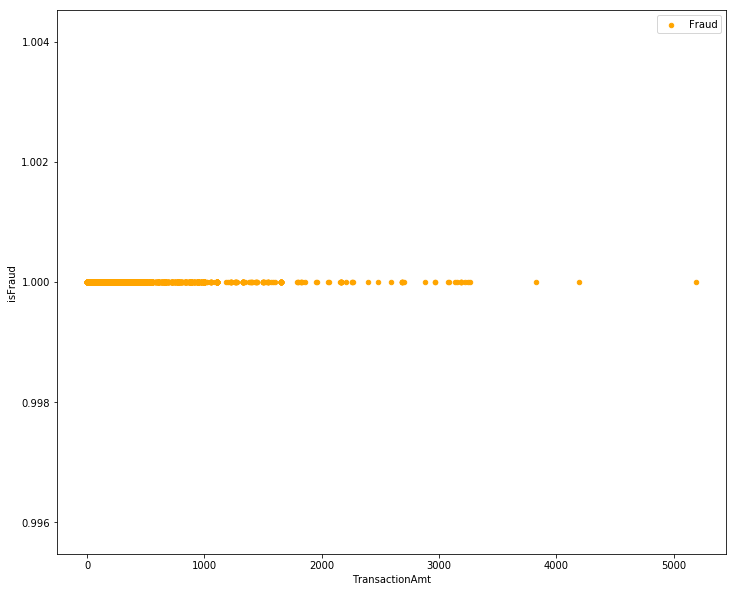

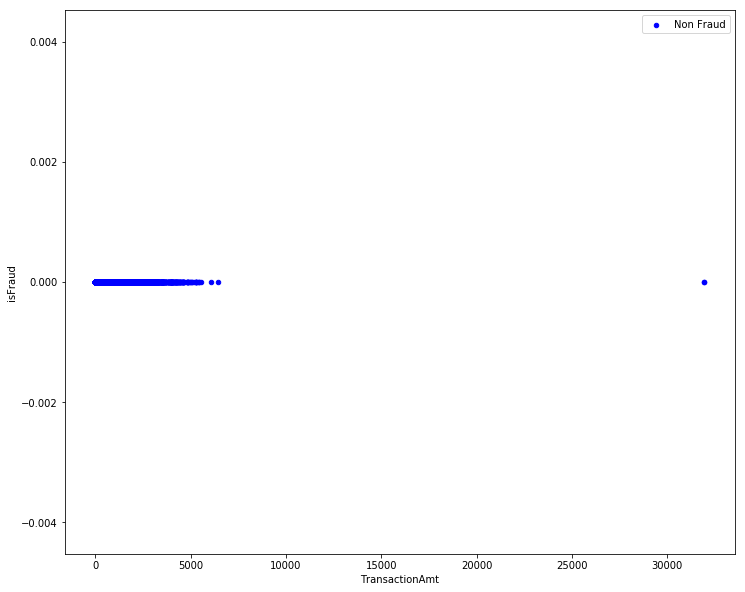

In [4]:
plt.rcParams['figure.figsize'] = (12,10)
ax = fraud.plot.scatter(x='TransactionAmt',y='isFraud',color='Orange',label='Fraud')
non_frauds = non_frauds.plot.scatter(x='TransactionAmt',y='isFraud',color='Blue',label='Non Fraud')
plt.show()

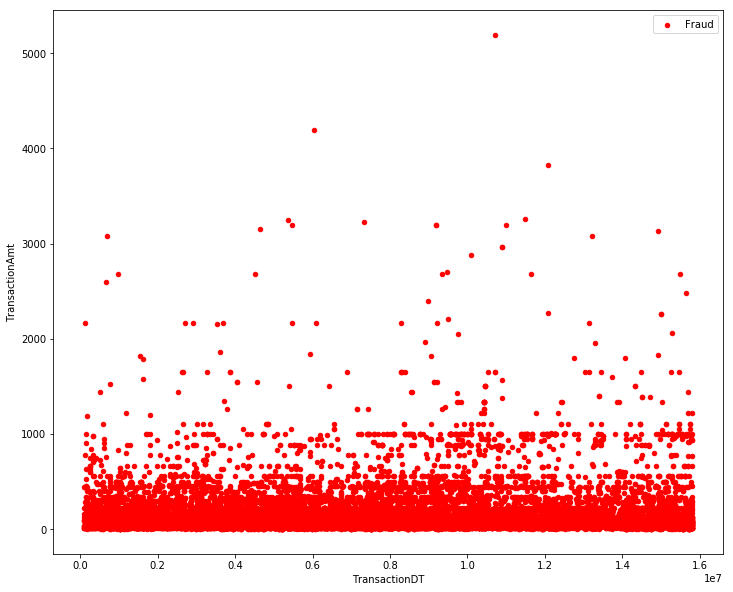

In [39]:
#Checking Fradualent transaction amount in training dataset
fraud.plot.scatter(x='TransactionDT',y='TransactionAmt',color='Red',label='Fraud')
#Observation - Fradualent Transaction are of low value and scattered across all the time

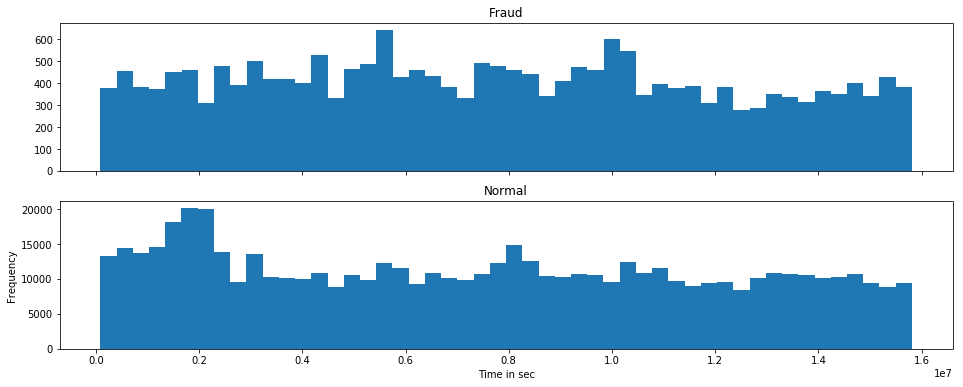

In [40]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,6))
ax1.hist(train.TransactionDT[train.isFraud == 1], bins = 50)
ax1.set_title('Fraud')
ax2.hist(train.TransactionDT[train.isFraud == 0], bins = 50)
ax2.set_title('Normal')
plt.xlabel('Time in sec')
plt.ylabel('Frequency')
plt.show()

Train data is a mix of data with categorical and numberical features.Separting the features columns

In [0]:
def col_feature(variable,first_col,last_col):
    return [variable + str(i) for i in range(first_col, last_col+1)]

In [0]:
trans_col = ['TransactionID', 'TransactionDT']
class_col = 'isFraud'
cat_col = (['ProductCD'] + col_feature('card', 1, 6) + ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            col_feature('M', 1, 9) + ['DeviceType', 'DeviceInfo'] + col_feature('id_', 12, 38))

In [0]:
numeric_col = [col for col in train.columns.tolist() if col not in cat_col + trans_col + [class_col]]

In [0]:
test_identity = pd.read_csv('gdrive/My Drive/Week3/test_identity.csv')
test_transaction = pd.read_csv('gdrive/My Drive/Week3/test_transaction.csv')
test = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [45]:
dffraud  = train[train.isFraud == 1]
dffraud.describe()                  #Check fraudulent transaction min and max amount along with few other variables stats

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,2.066300e+04,20663.0,2.066300e+04,20663.000000,20663.000000,20240.000000,20624.000000,20453.000000,12922.000000,12922.000000,4755.000000,3731.000000,20663.00000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20617.000000,7870.000000,9619.000000,14567.000000,10880.000000,7718.000000,5790.000000,7827.000000,7827.000000,16777.000000,6106.000000,7598.000000,6837.000000,7213.000000,...,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,11318.000000,11222.000000,7112.000000,7112.000000,10982.000000,10982.000000,426.000000,426.000000,7827.000000,7827.000000,11218.000000,10588.000000,3579.000000,11046.000000,3735.000000,11038.000000,11031.000000,426.000000,426.000000,402.000000,417.000000,425.000000,3451.000000
mean,3.294952e+06,1.0,7.690033e+06,149.244779,9547.654164,365.370850,162.368648,191.994328,294.317134,86.286024,174.588854,201.472259,35.53574,45.509413,0.000242,15.077336,1.406717,16.923148,11.977157,21.242608,1.703964,19.493926,23.857475,18.597541,24.967768,10.356047,38.711306,77.774206,11.744880,72.102904,13.687776,45.856439,11.292228,49.309191,0.520000,52.363653,87.314445,44.202553,6.492321,54.464578,...,1.600380,1.019262,0.069452,0.726262,0.290016,0.256104,0.377103,0.313619,90.384699,164.859468,127.633749,9.299240,49.394466,25.483993,37.742268,53.242268,45.496473,-16.075632,201522.569239,0.131749,-0.179696,1.473775,-8.213987,10.070423,-43.596244,0.175802,-0.210937,99.775677,47.289195,-319.681475,204.991400,14.497189,333.060156,435.838002,410.382629,18.727700,12.786070,340.764988,159.743529,27.716024
std,1.620403e+05,0.0,4.416551e+06,232.212163,4762.051380,159.623511,17.495775,45.779886,103.584955,4.936238,424.232313,451.589576,242.97626,287.813648,0.015554,125.673738,12.946092,126.298758,115.143177,176.695771,8.453280,176.919186,170.966234,162.082460,165.979050,82.902579,100.915599,128.697847,42.005468,140.656090,51.891635,101.424445,46.743057,133.254994,0.333188,127.051078,146.561013,99.349394,31.330429,126.586127,...,3.709768,2.257605,0.354930,2.788170,1.257701,0.786631,1.063497,0.960475,227.643019,436.287131,339.856944,51.502023,201.848261,117.938993,142.505208,190.250383,175.966280,20.397506,173522.003842,1.158604,1.315739,5.297058,16.966203,12.355698,27.651042,1.259368,1.464057,1.010306,12.314702,116.610454,29.822542,1.420988,126.113487,140.303630,241.117197,9.986157,2.993593,103.203530,31.768511,4.154470
min,2.987203e+06,1.0,8.976000e+04,0.292000,1015.000000,100.000000,100.000000,100.000000,110.000000,10.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,1.000000,-13.000000,-13.000000,-31.000000,-100.000000,-31.000000,-100.000000,-13.000000,-31.000000,90.000000,11.000000,-600.000000,100.000000,11.000000,100.000000,100.000000,142.000000,14.000000,11.000000,104.000000,100.000000,0.000000
25%,3.167366e+06,1.0,3.965858e+06,35.044000,5732.500000,204.000000,150.000000,138.000000,204.000000,87.000000,3.000000,7.000000,1.00000,1.000000,0.000000,0.000

In [46]:
train[cat_col].head()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [47]:
train[cat_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 49 columns):
ProductCD        590540 non-null object
card1            590540 non-null int64
card2            581607 non-null float64
card3            588975 non-null float64
card4            588963 non-null object
card5            586281 non-null float64
card6            588969 non-null object
addr1            524834 non-null float64
addr2            524834 non-null float64
P_emaildomain    496084 non-null object
R_emaildomain    137291 non-null object
M1               319440 non-null object
M2               319440 non-null object
M3               319440 non-null object
M4               309096 non-null object
M5               240058 non-null object
M6               421180 non-null object
M7               244275 non-null object
M8               244288 non-null object
M9               244288 non-null object
DeviceType       140810 non-null object
DeviceInfo       118666 non-null object
id_12

Need to convert categorical data based on features type

In [0]:
cat_col = train[cat_col].dtypes.pipe(lambda x: x[x == 'object']).index   #Converting all objects to numeric values

for c in cat_col:
    train[c] = pd.factorize(train[c])[0]

In [0]:
cat_col = test[cat_col].dtypes.pipe(lambda x: x[x == 'object']).index

for c in cat_col:
    test[c] = pd.factorize(train[c])[0]

In [50]:
train[cat_col].head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38
0,0,0,0,-1,-1,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,0,1,0,0,-1,-1,-1,-1,1,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,2,1,1,-1,0,0,0,1,0,1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,1,1,2,-1,-1,-1,-1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,1,1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0


In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(35)
memory usage: 1.9 GB


In [0]:
train.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

In [0]:
# Create an X_Train variable (containing the features) and an y_train variable (containing only the target variable)
X_train = train.drop(['isFraud'], axis=1)
y_train = train[class_col]


In [0]:
# Setting up varibles for test dataset
X_test = test.drop(['isFraud'], axis=1)
y_test = test[class_col]

In [0]:
# Scaling our data by creating an instance of the scaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
#Not normalizing the data instead we have scaled it
def normalize(X):
    """
    Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    """
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X

**Using various model to get the best fit**

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [25]:
logistic = linear_model.LogisticRegression(C=1e5,solver='lbfgs',max_iter=1000,verbose=1)

logistic.fit(X_train,y_train)

y_predicted_lr = np.array(logistic.predict(X_test))

print('Score:',logistic.score(X_test,y_test))

print('Confusion Matrix')
print(confusion_matrix(y_test, y_predicted_lr))
print('Classification Report')
print(classification_report(y_test, y_predicted_lr))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished


Score: 0.9719629491651709
Confusion Matrix
[[568323   1554]
 [ 15003   5660]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    569877
           1       0.78      0.27      0.41     20663

    accuracy                           0.97    590540
   macro avg       0.88      0.64      0.70    590540
weighted avg       0.97      0.97      0.97    590540



In [22]:
from sklearn.linear_model import SGDClassifier, LogisticRegression #Import packages related to Model
sgdclassifier = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
sgdclassifier.fit(X_train,y_train)

y_predicted_sg = np.array(sgdclassifier.predict(X_test))

print('Score:',sgdclassifier.score(X_test,y_test))

print('Confusion Matrix')
print(confusion_matrix(y_test, y_predicted_sg))
print('Classification Report')
print(classification_report(y_test, y_predicted_sg))


Score: 0.967985233853761
Confusion Matrix
[[569755    122]
 [ 18784   1879]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    569877
           1       0.94      0.09      0.17     20663

    accuracy                           0.97    590540
   macro avg       0.95      0.55      0.57    590540
weighted avg       0.97      0.97      0.96    590540



In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis #Import packages related to Model

quadclf = QuadraticDiscriminantAnalysis()

quadclf.fit(X_train,y_train)

y_predicted_qd = np.array(quadclf.predict(X_test))

print('Score:',quadclf.score(X_test,y_test))

print('Confusion Matrix')
print(confusion_matrix(y_test, y_predicted_qd))
print('Classification Report')
print(classification_report(y_test, y_predicted_qd))

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Score: 0.04734649642699902
Confusion Matrix
[[  7304 562573]
 [     7  20656]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.03    569877
           1       0.04      1.00      0.07     20663

    accuracy                           0.05    590540
   macro avg       0.52      0.51      0.05    590540
weighted avg       0.97      0.05      0.03    590540



In [17]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier #Import packages related to Model

randomforestcls = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

randomforestcls.fit(X_train,y_train)

y_predicted_rf = np.array(randomforestcls.predict(X_test))

print('Score:',randomforestcls.score(X_test,y_test))

print('Confusion Matrix')
print(confusion_matrix(y_test, y_predicted_rf))
print('Classification Report')
print(classification_report(y_test, y_predicted_rf))

Score: 0.9677295356792088
Confusion Matrix
[[569610    267]
 [ 18790   1873]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    569877
           1       0.88      0.09      0.16     20663

    accuracy                           0.97    590540
   macro avg       0.92      0.55      0.57    590540
weighted avg       0.96      0.97      0.95    590540



In [30]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier #Import packages related to Model
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
  gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=10, max_depth=8, random_state=0)
  gb_clf.fit(X_train, y_train)
  print("Learning rate: ", learning_rate)
  print("Accuracy score (training): {0:.6f}".format(gb_clf.score(X_train, y_train)))
  print("Accuracy score (validation): {0:.6f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.971706
Accuracy score (validation): 0.971441
Learning rate:  0.075
Accuracy score (training): 0.973472
Accuracy score (validation): 0.973282
Learning rate:  0.1
Accuracy score (training): 0.974444
Accuracy score (validation): 0.974329
Learning rate:  0.25
Accuracy score (training): 0.977195
Accuracy score (validation): 0.975411
Learning rate:  0.5
Accuracy score (training): 0.977837
Accuracy score (validation): 0.973059
Learning rate:  0.75
Accuracy score (training): 0.977436
Accuracy score (validation): 0.973424
Learning rate:  1
Accuracy score (training): 0.975494
Accuracy score (validation): 0.961947


Learning rate of 0.5 using Gradient Boost Classification gives the best result so we will be using it to calculate final prediction

In [31]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=10, max_depth=8, random_state=0)
gb_clf2.fit(X_train, y_train)

y_predicted_gb = gb_clf2.predict(X_test)
print('Score:',gb_clf2.score(X_test,y_test))
print('Confusion Matrix')
print(confusion_matrix(y_test, y_predicted_gb))
print('Classification Report')
print(classification_report(y_test, y_predicted_gb))

Score: 0.9730585565753378
Confusion Matrix
[[565162   4715]
 [ 11195   9468]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    569877
           1       0.67      0.46      0.54     20663

    accuracy                           0.97    590540
   macro avg       0.82      0.72      0.76    590540
weighted avg       0.97      0.97      0.97    590540



In [0]:
#picking the best predicted value

In [0]:
test['isFraud'] = y_predicted_gb
test[['TransactionID', 'isFraud']].to_csv('gdrive/My Drive/Week3/sample_submission_result.csv', index=False)